In [1]:
# !pip install gymnasium
# !pip install swig
# !pip install gymnasium[box2d]
# !pip install gymnasium[classic_control]
# !pip install gymnasium[mujoco]

In [2]:
# !pip3 install numpngw


In [1]:
# Models and computation
import torch # will use pyTorch to handle NN
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from random import sample

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from numpngw import write_apng

# IO
from pathlib import Path
import os
from torch.distributions import MultivariateNormal, Normal,Beta
import gymnasium as gym


In [5]:
env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=True)
# env

In [6]:
env.observation_space.shape,env.action_space

((96, 96, 3), Box([-1.  0.  0.], 1.0, (3,), float32))

In [13]:
images = []
s,_ = env.reset()
# print(s)
img = env.render()
images.append(img)

done = False
steps = 0

while not done:
    action = env.action_space.sample()
    steps += 1
    # print(env.step(action))
    obs, reward, done, _,_ = env.step(action)
    img = env.render()
    images.append(img)
    if steps > 160:
      break
env.close()

In [ ]:
s,_ = env.reset()
# print(s)
img = env.render()
images.append(img)
plt.imshow(img)  # if state is a 3D tensor (e.g., (1, H, W, C))
plt.show()

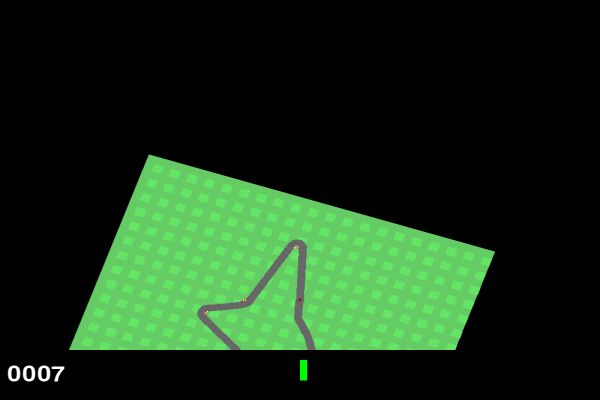

In [8]:
write_apng('anim.png', images, delay=20)
Image(filename='anim.png')

In [4]:
# from google.colab import drive
# from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space

    Parameters
    ----------
    model: your policy network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    # if mode == 1:
    #   drive.mount('/content/gdrive')
    #   path = F"/content/gdrive/My Drive/{filename}"
    #   torch.save(model.state_dict(), path)
    # else:
    torch.save(model.state_dict(), filename)

# def export_to_local_drive(filename):
#     """
#     Download a file to your local machine

#     Parameters
#     ----------
#     filename: the name of the file
#     """
#     files.download(filename)


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
from collections import deque
import numpy as np

# class FrameStackWrapper:
#     def __init__(self, env, num_frames):
#         self.env = env
#         self.num_frames = num_frames
#         self.frames = deque(maxlen=num_frames)
        
#     def reset(self):
#         state, info = self.env.reset()
#         for _ in range(self.num_frames):
#             normalized_state = self.normalize_state(state)
#             self.frames.append(normalized_state)
#             # self.frames.append(state)
#         return np.concatenate(self.frames, axis=2), info
    
#     def normalize_state(self,state):
#       return (state - state.min()) / (state.max() - state.min() + 1e-8)

#     def step(self, action):
#         state, reward, done, truncated, info = self.env.step(action)
#         normalized_state = self.normalize_state(state)
#         self.frames.append(normalized_state)
#         # self.frames.append(state)
#         return np.concatenate(self.frames, axis=2), reward, done, truncated, info

#     def render(self):
#         return self.env.render()

#     def close(self):
#         self.env.close()


from collections import deque
import numpy as np

class FrameStackWrapper:
    def __init__(self, env, num_frames):
        """
        Environment wrapper for frame stacking and reward adjustments.
        """
        self.env = env
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
        self.reward_threshold = self.env.spec.reward_threshold

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb, _ = self.env.reset()
        img_grey = self.rgb2gray(img_rgb)
        # nor_img = self.normalize_state(img_grey)

        self.frames = deque([img_grey] * self.num_frames, maxlen=self.num_frames)
        return np.stack(self.frames), _

    # def step(self, action, action_repeat=1):
    #     total_reward = 0
    #     for i in range(action_repeat):
    #         img_rgb, reward, done, truncated, info = self.env.step(action)
            
    #         if np.mean(img_rgb[:, :, 1]) > 185.0:
    #             reward -= 0.05
            
    #         total_reward += reward
            
    #         if self.av_r(reward) <= -0.1 or done:
    #             done = True
    #             break
        
    #     # Calculate average reward
    #     avg_reward = total_reward / (i + 1)  # i + 1 because i starts from 0
        
    #     img_gray = self.rgb2gray(img_rgb)
    #     img_norm = self.normalize_state(img_gray)

    #     self.frames.append(img_norm)
        
    #     return np.stack(self.frames), avg_reward, done, truncated, info

    def step(self, action):
        total_reward = 0
        for i in range(4):
            img_rgb, reward, die, _,_ = self.env.step(action)
            # don't penalize "die state"
            if die:
                reward += 10
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 120.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = self.rgb2gray(img_rgb)
        # img_norm = self.normalize_state(img_gray)
        # avg_reward = total_reward / (i + 1)  # i + 1 because i starts from 0

        self.frames.append(img_gray)
        return np.stack(self.frames), total_reward, die, done,_


    @staticmethod
    def rgb2gray(rgb):
        # rgb image -> gray [0, 1]
        gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
        return gray
    
    def render(self):
        """
        Renders the environment.
        """
        return self.env.render()

    def close(self):
        """
        Closes the environment.
        """
        self.env.close()

    # def normalize_state(self,state):
    #     """
    #     Normalizes the state to [0, 1].
    #     """
    #     return (state - state.min()) / (state.max() - state.min() + 1e-8)

    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory


In [17]:
class PPO_PolicyNetwork(nn.Module):
    def __init__(self, input_shape, output_dim):
        super(PPO_PolicyNetwork, self).__init__()
        # Convolutional layers for feature extraction
        self.cnn_base = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=4, stride=2),   # (96, 96, 3) -> (8, 47, 47)
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),               # (8, 47, 47) -> (16, 23, 23)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),              # (16, 23, 23) -> (32, 11, 11)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),              # (32, 11, 11) -> (64, 5, 5)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)

        # self.lstm = nn.LSTM(input_size=576, hidden_size=128, batch_first=True)
        self.alpha_head = nn.Sequential(nn.Linear(128, output_dim), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(128, output_dim), nn.Softplus())
     
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        # print(x.shape)
        # x = x.permute(0, 3, 1, 2)  # Convert NHWC (Gym) to NCHW (PyTorch)
        x = self.cnn_base(x)
        # print(x.shape)
        # x = x.view(-1, 576)
        # x = x.reshape(x.size(0), -1) 
        x = x.view(-1, 256)

        x = F.relu(self.fc1(x))

        # x = x.unsqueeze(1)  # Add sequence dimension
        # lstm_out, _ = self.lstm(x)  # LSTM expects input shape (batch_size, seq_len, input_size)
        # x = lstm_out[:, -1]  # Get the last output from LSTM
        alpha = self.alpha_head(x)+1
        beta = self.beta_head(x) +1
        return alpha,beta

    def select_action(self, state):
        # state = torch.from_numpy(state).float().unsqueeze(0).to(device)  # Add batch dimension
        # print(state.shape)
        if(len(state.shape)==3):
          state = torch.from_numpy(state).float().unsqueeze(0).to(device)  # Add batch dimension
        else:
          state = torch.from_numpy(state).float().to(device)  # Add batch dimension
        alpha,beta = self.forward(state)
        n_dist = Beta(alpha, beta)
        action = n_dist.sample()
        action = torch.clamp(action,0,1)
        # action[0][0] = 2 * action[0][0] - 1  # Transform the first action (steering) to [-1, 1]
        logproba = n_dist.log_prob(action)
        entropy = n_dist.entropy()
        # print(action.shape)


        return action.cpu().numpy()[0], logproba.sum(-1), entropy.sum(-1)

    def evaluate_action(self, state,action):
      # print(state.shape)
      
    #   state = torch.from_numpy(state).float().to(device)
      if(len(state.shape)==3):
          state = torch.from_numpy(state).float().unsqueeze(0).to(device)  # Add batch dimension
      else:
          state = torch.from_numpy(state).float().to(device)  # Add batch dimension
      alpha,beta = self.forward(state)
      n_dist = Beta(alpha, beta)
      # n_dist = Normal(mu,0.1)
      action = action.to(device)
      action = torch.clamp(action,0,1)

      logproba = n_dist.log_prob(action)
      return logproba.sum(-1)


    # def select_greedy_action(self, state):
    # #   state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    #   if(len(state.shape)==3):
    #       state = torch.from_numpy(state).float().unsqueeze(0).to(device)  # Add batch dimension
    #   else:
    #       state = torch.from_numpy(state).float().to(device)  # Add batch dimension
    #   alpha,beta = self.forward(state)
    #     # Add clamping for stability
    #   epsilon = 1e-6
    #   # alpha = torch.clamp(alpha, min=1 + epsilon)
    #   # beta = torch.clamp(beta, min=1 + epsilon)

    #   # Compute greedy action with stability
    #   greedy_action = (alpha - 1) / (alpha + beta - 2 + epsilon)
    #   greedy_action = torch.clamp(greedy_action, 0, 1)
    #   # greedy_action = (alpha - 1) / (alpha + beta - 2)
    #   # greedy_action[0][0] = 2 * greedy_action[0][0] - 1  # Transform the first action (steering) to [-1, 1]
    #   # greedy_action = torch.clamp(greedy_action, 0, 1)

    #   return greedy_action.detach().cpu().numpy()[0]


class PPO_ValueNetwork(nn.Module):
    def __init__(self, input_shape):
        super(PPO_ValueNetwork, self).__init__()
        # Convolutional layers for feature extraction
        self.cnn_base = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=4, stride=2),   # (96, 96, 3) -> (8, 47, 47)
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),               # (8, 47, 47) -> (16, 23, 23)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),              # (16, 23, 23) -> (32, 11, 11)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),              # (32, 11, 11) -> (64, 5, 5)
            nn.ReLU(),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        # Fully connected layers
        # Fully connected layers
                # LSTM layer
        # self.lstm = nn.LSTM(input_size=576, hidden_size=128,
        #                     batch_first=True)

        # Fully connected layers
        # self.fc1 = nn.Linear(128, 128)
        # self.fc2 = nn.Linear(128, 1)
        
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)

        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

            
    def forward(self, state):
        if(len(state.shape)==3):
          state = torch.from_numpy(state).float().unsqueeze(0).to(device)  # Add batch dimension
        else:
          state = torch.from_numpy(state).float().to(device)  # Add batch dimension
        # state = state.permute(0, 3, 1, 2)  # Convert NHWC to NCHW
        x = self.cnn_base(state)
        # print(x.shape)
        # x = x.view(-1, 576)
        # x = x.reshape(x.size(0), -1) 
        x = x.view(-1, 256)

        x = F.relu(self.fc1(x))
        value = self.fc2(x)
        return value
        # x = x.unsqueeze(1)  # Add sequence dimension for LSTM

        # lstm_out, _ = self.lstm(x)  # Get the output from LSTM
        # lstm_out = lstm_out[:, -1]   # Take the last output for value prediction
        
        # x = F.relu(self.fc1(lstm_out))
        # value = self.fc2(x)
        
        # return value


In [18]:
######################## Your code ####################################
class PPO_ACAgent():
    def __init__(self, state_size, action_size, pi_lr, vf_lr, entropy_weight, value_epochs):
        self.state_size = state_size
        self.action_size = action_size
        self.pi_lr = pi_lr
        self.vf_lr = vf_lr
        self.entropy_weight = entropy_weight
        self.value_epochs = value_epochs
        self.policy_epochs = 3
        self.eps_clip = 0.2

        self.pnetwork = PPO_PolicyNetwork(state_size, action_size).to(device)
        self.vnetwork = PPO_ValueNetwork(state_size).to(device)

        self.policy_optimizer = optim.Adam(self.pnetwork.parameters(), lr=self.pi_lr)
        self.value_optimizer = optim.Adam(self.vnetwork.parameters(), lr=self.vf_lr)

    def evaluate(self, env, n_rollouts=1):
        rewards = []
        for _ in range(n_rollouts):
            state, _ = env.reset()
            done = False
            truncated = False
            rewards.append(0)
            # max_steps = 500
            # steps = 0
            while not done and not truncated:
                # state = self.normalize_state(state)
                action, _, _ = self.pnetwork.select_action(state)

                # action = self.pnetwork.select_greedy_action(state)
                # print(action)
                state, reward, done, truncated,_ = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
                rewards[-1] += reward
                # steps += 1
        return np.mean(rewards), np.std(rewards)


    def returns_to_go_advantage(self, rewards, values, gamma=0.99):
        returns = np.zeros(len(rewards))
        g = 0  # Initialize return accumulator
        for t in reversed(range(len(rewards))):
            g = rewards[t] + gamma * g
            returns[t] = g  # Insert at the beginning to maintain order

        # Convert returns and values to tensors
        returns_tensor = torch.tensor(returns, dtype=torch.float32)
        values_tensor = torch.tensor(values, dtype=torch.float32)

        # Calculate advantages
        advantages_tensor = returns_tensor - values_tensor

        return advantages_tensor, returns_tensor

    # def returns_to_go_advantage(self, rewards, values, gamma=0.99, lam=0.95):
    #   advantages = []
    #   gae = 0
    #   for i in reversed(range(len(rewards))):
    #       if i == len(rewards) - 1:
    #           delta = rewards[i] - values[i]
    #       else:
    #           delta = rewards[i] + gamma * values[i+1] - values[i]
          
    #       gae = delta + gamma * lam * gae
    #       advantages.insert(0, gae)
    #   advantages = torch.tensor(advantages, dtype=torch.float32)
    #   values = torch.tensor(values, dtype=torch.float32)
    # #   print(advantages.shape,values.shape)

    #   returns = advantages + values
      
    #   return advantages, returns



    # def adaptive_entropy_decay(self,episode, total_episodes, initial_entropy=0.01, final_entropy=0.001):
    #     """
    #     Cosine annealing of entropy weight
    #     Provides a smooth decay from initial to final entropy
    #     """
    #     progress = episode / total_episodes
    #     return final_entropy + 0.5 * (initial_entropy - final_entropy) * (1 + np.cos(np.pi * progress))
    def adaptive_entropy_decay(self, episode, total_episodes, 
                                initial_entropy=0.01, final_entropy=0.001):
        progress = episode / total_episodes
        return initial_entropy * (1 - progress) + final_entropy * progress

    def learn(self):
        # Convert to tensors with proper detachment
        self.advantages = torch.tensor(self.advantages, dtype=torch.float32)

        # More robust advantage normalization
        advantages_normalized = (self.advantages - self.advantages.mean()) / (self.advantages.std() + 1e-4)

        self.log_probs = torch.tensor(self.log_probs)
        self.entropies = torch.tensor(self.entropies)

        indices = np.arange(len(self.states))
        batch_size = min(256, len(self.states))  # Adaptive batch size

        # Policy Network Update
        for _ in range(self.policy_epochs):
            # Shuffled sequential batches instead of random sampling
            np.random.shuffle(indices)
            for start in range(0, len(indices), batch_size):
                batch_indices = indices[start:start+batch_size]

                batch_states = np.array(self.states)[batch_indices]
                batch_advantages = advantages_normalized[batch_indices]
                batch_actions = np.array(self.actions)[batch_indices]
                batch_logproba = self.log_probs[batch_indices]
                action_tensors = torch.stack([torch.from_numpy(action).float() for action in batch_actions])
                batch_entropies = self.entropies[batch_indices]

                # Entropy regularization
                entropy_loss = batch_entropies.mean()

                # Compute new log probabilities
                new_logprobs = self.pnetwork.evaluate_action(batch_states, action_tensors)

                # PPO clipped surrogate objective
                ratios = torch.exp(new_logprobs - batch_logproba.detach().to(device))
                surr1 = ratios * batch_advantages.to(device)
                surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * batch_advantages.to(device)
                policy_loss = -torch.min(surr1, surr2).mean() - self.entropy_weight * entropy_loss.to(device)

                # Optimization step with gradient clipping
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.pnetwork.parameters(), max_norm=1.0)
                self.policy_optimizer.step()

        # Value Network Update
        for _ in range(self.value_epochs):
            np.random.shuffle(indices)
            for start in range(0, len(indices), batch_size):
                batch_indices = indices[start:start+batch_size]

                batch_targets = torch.tensor(np.array(self.targets)[batch_indices], dtype=torch.float32).unsqueeze(1)
                batch_states = np.array(self.states)[batch_indices]

                # More stable value loss computation
                values_pred = self.vnetwork(batch_states)
                value_loss = F.mse_loss(values_pred, batch_targets.to(device))

                # Optimization step with gradient clipping
                self.value_optimizer.zero_grad()
                value_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.vnetwork.parameters(), max_norm=1.0)
                self.value_optimizer.step()

    # def normalize_state(self,state):
    #   return (state - state.min()) / (state.max() - state.min() + 1e-8)

    def train(self, env, seed, gamma, max_episodes, max_episode_steps, goal_mean_100_reward,entropy):

        self.seed = seed
        self.gamma = gamma
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        # these are for bookkeeping and statistics
        self.evaluation_scores = []
        self.episode_reward = []
        self.total_steps = 0
        result = np.empty((max_episodes, 3))
        result[:] = np.nan
        self.entropy_weight_end = 0.001
        env = FrameStackWrapper(env, num_frames=4)

        for episode in range(1, max_episodes + 1):
            self.actions = []
            self.rewards = [] # step rewards
            self.values = [] # value function
            self.log_probs = [] # storing the log probability of selected actions
            self.entropies = [] # storing the entropy of the action policy
            self.states = [] # storing the states
            self.advantages = [] # storing the advantages
            self.targets = [] # storing the targets
            episode_steps = 0 # steps for the current rollout
            self.episode_reward.append(0.0) # keep track of the rollout reward
            initial_entropy_weight = entropy
            final_entropy_weight = 0.001
            self.entropy_weight = self.adaptive_entropy_decay(
              episode,
              max_episodes,
              initial_entropy=initial_entropy_weight,
              final_entropy=final_entropy_weight
            )

            step_counter = 0
            while step_counter < max_episode_steps:

              traj_rewards = []
              traj_values = []
              traj_log_probs = []
              traj_entropies = []
              traj_states = []
              traj_actions = []

              state, _ = env.reset()
              # print(state.shape,state.mean(),state.std())
              # is_terminal = False

              traj_steps = 0
              max_traj_steps = 500
              while traj_steps<max_traj_steps: #lazy approach where the training batch consists of one trajectory
                  # plt.imshow(state)  # if state is a 3D tensor (e.g., (1, H, W, C))
                  # plt.show()
                #   state = self.normalize_state(state)
                  traj_states.append(state)
                  # print(state.shape)
                  
                  with torch.no_grad():
                    action, logprob_action, entropy = self.pnetwork.select_action(state)
                  # print(action.shape)
                  # print(action)
                  new_state, reward, is_done, truncated,_ = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
                  # print(reward)
                  # print(is_done, truncated)
                  traj_log_probs.append(logprob_action)
                  traj_rewards.append(reward)
                  traj_entropies.append(entropy)
                  traj_actions.append(action)
                  with torch.no_grad():
                    traj_values.append(self.vnetwork(state))

                  self.episode_reward[-1] += reward
                  self.total_steps +=1
                  episode_steps +=1
                  step_counter +=1
                  traj_steps+=1
                  state = new_state


                  # print(new_state.shape,state.mean(),state.std())
                  # reached the max number of steps per episode?
                  timeout = step_counter == max_episode_steps
                  # handling the end of a rollout or the end of an iteration
                  traje_out = traj_steps == max_traj_steps

                  if is_done or timeout or traje_out or truncated:
                      traj_values = torch.cat(traj_values)
                      np_values = traj_values.view(-1).data.cpu().numpy()
                      advantages,returns_to_go = self.returns_to_go_advantage(traj_rewards,np_values,self.gamma)
                      self.advantages.extend(advantages)
                      self.targets.extend(returns_to_go)## flattening
                      break

              self.rewards.extend(traj_rewards)
              # print(traj_rewards)
              self.values.extend(np_values)
              self.log_probs.extend(traj_log_probs)
              self.entropies.extend(traj_entropies)
              self.states.extend(traj_states) ## flattening
              self.actions.extend(traj_actions)

            self.learn()


            # bookkeeping
            evaluation_score, _ = self.evaluate(env) # evaluation rollout using the greedy policy
            self.evaluation_scores.append(evaluation_score)

            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = self.total_steps, mean_100_reward, mean_100_eval_score

            print('Total Steps: {:d}, Train_reward: {:.2f}, Eval_reward: {:.2f}'.format(self.total_steps,\
                  mean_100_reward, mean_100_eval_score))

            # the problem considered solved if the average score over 100 consecutive trials is above
            #goal_mean_100_reward
            training_is_over = episode >= max_episodes or \
                               mean_100_eval_score >= goal_mean_100_reward
            if training_is_over:
                if episode >= max_episodes: print('--> reached_max_episodes')
                if mean_100_eval_score >= goal_mean_100_reward:
                    print('Environment solved in {:d} steps!\tAverage Score: {:.2f}'.format(self.total_steps, mean_100_eval_score))
                break

        return np.array(result) #result


    def save_checkpoint(self, filename):
        torch.save(self.pnetwork.state_dict(), filename)

    def load_checkpoint(self, model_name):
        self.pnetwork.load_state_dict(torch.load(model_name))

In [22]:
# Main training loop
env1 = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.25, domain_randomize=False, continuous=True)
pi_lr = 5e-4
vf_lr = 1e-3
gamma = .99
entropy_weight = 0.02#changing this help
#value network rewards to go
value_epochs = 5
max_episodes = 200
max_episode_steps = 2000#env1.spec.max_episode_steps  # you could set your own time limit
goal_mean_100_reward = env1.spec.reward_threshold # that's Gym specific
seed = 42

# env1.seed(seed)
ppoagent = PPO_ACAgent(env1.observation_space.shape, env1.action_space.shape[0], pi_lr, vf_lr, entropy_weight, value_epochs)
result_ppo = ppoagent.train(env1, seed, gamma, max_episodes, max_episode_steps, goal_mean_100_reward,entropy_weight)

env1.close()
del env1

Total Steps: 2000, Train_reward: -619.15, Eval_reward: 11.60
Total Steps: 4000, Train_reward: -145.05, Eval_reward: 9.57
Total Steps: 6000, Train_reward: -1.97, Eval_reward: 6.78
Total Steps: 8000, Train_reward: 69.70, Eval_reward: 19.20
Total Steps: 10000, Train_reward: 130.98, Eval_reward: 18.81
Total Steps: 12000, Train_reward: 166.30, Eval_reward: 15.81
Total Steps: 14000, Train_reward: 214.87, Eval_reward: 13.69
Total Steps: 16000, Train_reward: 229.38, Eval_reward: 14.73
Total Steps: 18000, Train_reward: 287.88, Eval_reward: 17.26
Total Steps: 20000, Train_reward: 321.91, Eval_reward: 22.67
Total Steps: 22000, Train_reward: 368.01, Eval_reward: 26.72
Total Steps: 24000, Train_reward: 420.67, Eval_reward: 26.36
Total Steps: 26000, Train_reward: 460.57, Eval_reward: 39.42
Total Steps: 28000, Train_reward: 512.86, Eval_reward: 39.67
Total Steps: 30000, Train_reward: 567.60, Eval_reward: 42.96
Total Steps: 32000, Train_reward: 628.38, Eval_reward: 44.98
Total Steps: 34000, Train_rewa

In [35]:
# Main training loop
env1 = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.50, domain_randomize=False, continuous=True)
# pi_lr = 5e-4
# vf_lr = 1e-3
# gamma = .99
entropy_weight = 0.01#changing this help
# #value network rewards to go
# value_epochs = 5
max_episodes = 200
max_episode_steps = 2000#env1.spec.max_episode_steps  # you could set your own time limit
# goal_mean_100_reward = env1.spec.reward_threshold # that's Gym specific
# seed = 42

# env1.seed(seed)
# ppoagent = PPO_ACAgent(env1.observation_space.shape, env1.action_space.shape[0], pi_lr, vf_lr, entropy_weight, value_epochs)
result_ppo1 = ppoagent.train(env1, seed, gamma, max_episodes, max_episode_steps, goal_mean_100_reward,entropy_weight)

env1.close()
del env1

Total Steps: 2000, Train_reward: 4715.06, Eval_reward: 763.89
Total Steps: 4000, Train_reward: 4537.97, Eval_reward: 786.41
Total Steps: 6000, Train_reward: 4350.80, Eval_reward: 801.83
Total Steps: 8000, Train_reward: 4532.27, Eval_reward: 797.72
Total Steps: 10000, Train_reward: 4536.13, Eval_reward: 798.93
Total Steps: 12000, Train_reward: 4636.06, Eval_reward: 797.36
Total Steps: 14000, Train_reward: 4642.92, Eval_reward: 797.15
Total Steps: 16000, Train_reward: 4593.76, Eval_reward: 803.54
Total Steps: 18000, Train_reward: 4640.84, Eval_reward: 780.42
Total Steps: 20000, Train_reward: 4579.99, Eval_reward: 780.92
Total Steps: 22000, Train_reward: 4601.47, Eval_reward: 784.25
Total Steps: 24000, Train_reward: 4568.44, Eval_reward: 731.06
Total Steps: 26000, Train_reward: 4568.30, Eval_reward: 733.36
Total Steps: 28000, Train_reward: 4588.56, Eval_reward: 715.40
Total Steps: 30000, Train_reward: 4589.52, Eval_reward: 717.78
Total Steps: 32000, Train_reward: 4567.42, Eval_reward: 688

In [40]:
env1 = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.5, domain_randomize=False, continuous=True)
# pi_lr = 5e-4
# vf_lr = 1e-4
# gamma = .99
entropy_weight = 0.0001#changing this help
#value network rewards to go
value_epochs = 5
max_episodes = 300
max_episode_steps = 2000#env1.spec.max_episode_steps  # you could set your own time limit
goal_mean_100_reward = env1.spec.reward_threshold # that's Gym specific
# seed = 42

# env1.seed(seed)
# ppoagent = PPO_ACAgent(env1.observation_space.shape, env1.action_space.shape[0], pi_lr, vf_lr, entropy_weight, value_epochs)
result_ppo2 = ppoagent.train(env1, seed, gamma, max_episodes, max_episode_steps, goal_mean_100_reward,entropy_weight)

env1.close()
del env1

Total Steps: 2000, Train_reward: 5409.37, Eval_reward: 366.13
Total Steps: 4000, Train_reward: 5651.87, Eval_reward: 608.27
Total Steps: 6000, Train_reward: 5681.94, Eval_reward: 692.14
Total Steps: 8000, Train_reward: 5698.59, Eval_reward: 654.56
Total Steps: 10000, Train_reward: 5852.95, Eval_reward: 692.70
Total Steps: 12000, Train_reward: 5811.65, Eval_reward: 603.34
Total Steps: 14000, Train_reward: 5843.74, Eval_reward: 644.54
Total Steps: 16000, Train_reward: 5770.63, Eval_reward: 575.82
Total Steps: 18000, Train_reward: 5867.05, Eval_reward: 601.20
Total Steps: 20000, Train_reward: 5758.07, Eval_reward: 555.36
Total Steps: 22000, Train_reward: 5780.91, Eval_reward: 580.47
Total Steps: 24000, Train_reward: 5827.74, Eval_reward: 601.90
Total Steps: 26000, Train_reward: 5855.41, Eval_reward: 618.28
Total Steps: 28000, Train_reward: 5892.03, Eval_reward: 631.81
Total Steps: 30000, Train_reward: 5902.92, Eval_reward: 630.52
Total Steps: 32000, Train_reward: 5859.51, Eval_reward: 610

In [44]:
env1 = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.5, domain_randomize=False, continuous=True)
# pi_lr = 5e-4
# vf_lr = 1e-4
# gamma = .99
entropy_weight = 0.0001#changing this help
#value network rewards to go
value_epochs = 5
max_episodes = 100
max_episode_steps = 2000#env1.spec.max_episode_steps  # you could set your own time limit
goal_mean_100_reward = env1.spec.reward_threshold # that's Gym specific
# seed = 42

# env1.seed(seed)
# ppoagent = PPO_ACAgent(env1.observation_space.shape, env1.action_space.shape[0], pi_lr, vf_lr, entropy_weight, value_epochs)
result_ppo3 = ppoagent.train(env1, seed, gamma, max_episodes, max_episode_steps, goal_mean_100_reward,entropy_weight)

env1.close()
del env1

Total Steps: 2000, Train_reward: 6094.62, Eval_reward: 866.55
Total Steps: 4000, Train_reward: 5548.04, Eval_reward: 866.77
Total Steps: 6000, Train_reward: 5607.45, Eval_reward: 825.64
Total Steps: 8000, Train_reward: 5757.91, Eval_reward: 709.65
Total Steps: 10000, Train_reward: 5919.01, Eval_reward: 743.88
Total Steps: 12000, Train_reward: 5860.03, Eval_reward: 737.32
Total Steps: 14000, Train_reward: 5807.10, Eval_reward: 719.66
Total Steps: 16000, Train_reward: 5772.41, Eval_reward: 652.76
Total Steps: 18000, Train_reward: 5705.12, Eval_reward: 624.16
Total Steps: 20000, Train_reward: 5714.96, Eval_reward: 650.71
Total Steps: 22000, Train_reward: 5720.43, Eval_reward: 666.36
Total Steps: 24000, Train_reward: 5675.87, Eval_reward: 645.14
Total Steps: 26000, Train_reward: 5637.05, Eval_reward: 655.03
Total Steps: 28000, Train_reward: 5664.60, Eval_reward: 670.85
Total Steps: 30000, Train_reward: 5680.01, Eval_reward: 666.81
Total Steps: 32000, Train_reward: 5727.41, Eval_reward: 668

In [41]:
def save_results(array, filename):
  np.save(filename, array)

In [42]:
save_results(result_ppo2,'result_ppo_rcF4.npy')

In [43]:
save_checkpoint(ppoagent.pnetwork,'ppo_pnetwork_race_carF4.pt')
save_checkpoint(ppoagent.vnetwork,'ppo_vnetwork_race_carF4.pt')

In [36]:
env1 = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.5, domain_randomize=False, continuous=True)

env2 = FrameStackWrapper(env1, num_frames=4)

images = []
s,_ = env2.reset()
print(s.shape)
img = env2.render()
# print(img.shape)
# plt.imshow(img)  # if state is a 3D tensor (e.g., (1, H, W, C))
# plt.show()
images.append(img)

done = False
steps = 0
truncated = False
while not done:
    action,_,_ = ppoagent.pnetwork.select_action(s)
    steps += 1
    # print(env.step(action))
    obs, reward, done, truncated,_ = env2.step(action)
    # print(done,truncated)
    img = env2.render()
    images.append(img)
    if steps > 160:
      break
env2.close()

(4, 96, 96)


In [ ]:
write_apng('anim3.png', images, delay=20)
Image(filename='anim3.png')